In [1]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd
import sys

#Sampling
from pyDOE import lhs
from scipy.interpolate import griddata
from smt.sampling_methods import LHS
import random

import torch
from botorch.models.gp_regression import HeteroskedasticSingleTaskGP
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import normalize
from gpytorch.mlls import ExactMarginalLogLikelihood


In [2]:
#data_summary = pd.read_csv('data_out_iter3.csv')
data_r1 = pd.read_csv('../Round1/extracted_data_round1.csv')
data_r2A = pd.read_csv('../Round2/ModelA/extracted_data_round2A.csv')
data_r2B = pd.read_csv('../Round2/ModelB/extracted_data_round2B.csv')
data_r2C = pd.read_csv('../Round2/ModelC/extracted_data_round2C.csv')
data_r3A = pd.read_csv('../Round3/ModelA/extracted_data_round3A.csv')
data_r3B = pd.read_csv('../Round3/ModelB/extracted_data_round3B.csv')
data_r3C = pd.read_csv('../Round3/ModelC/extracted_data_round3C.csv')
data_redo =pd.read_csv('../Round_Redo/extracted_data_round_redo.csv')

# Deviec set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [3]:
raw_data01 = data_r1[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})

raw_data2A = data_r2A[['2A_time','2A_temp','2A_sulf','2A_anly','2A_yield product']].rename(columns = {'2A_time':"time",'2A_temp':"temp",'2A_sulf':"sulf",'2A_anly':"anly",'2A_yield product':"yield product"})
raw_data2B = data_r2B[['2B_time','2B_temp','2B_sulf','2B_anly','2B_yield product']].rename(columns = {'2B_time':"time",'2B_temp':"temp",'2B_sulf':"sulf",'2B_anly':"anly",'2B_yield product':"yield product"})
raw_data2C = data_r2C[['2C_time','2C_temp','2C_sulf','2C_anly','2C_yield product']].rename(columns = {'2C_time':"time",'2C_temp':"temp",'2C_sulf':"sulf",'2C_anly':"anly",'2C_yield product':"yield product"})

raw_data3A = data_r3A[['3A_time','3A_temp','3A_sulf','3A_anly','3A_yield product']].rename(columns = {'3A_time':"time",'3A_temp':"temp",'3A_sulf':"sulf",'3A_anly':"anly",'3A_yield product':"yield product"})
raw_data3B = data_r3B[['3B_time','3B_temp','3B_sulf','3B_anly','3B_yield product']].rename(columns = {'3B_time':"time",'3B_temp':"temp",'3B_sulf':"sulf",'3B_anly':"anly",'3B_yield product':"yield product"})
raw_data3C = data_r3C[['3C_time','3C_temp','3C_sulf','3C_anly','3C_yield product']].rename(columns = {'3C_time':"time",'3C_temp':"temp",'3C_sulf':"sulf",'3C_anly':"anly",'3C_yield product':"yield product"})
raw_dataredo = data_redo[['model ID','time','temp','sulf','anly','yield product']]

all_data_raw = pd.concat([raw_data01,raw_data2A,raw_data2B,raw_data2C,raw_data3A[raw_data2A['time'] != 502],raw_data3B[~raw_data2B['time'].isin([261, 295, 552, 595])],raw_data3C[~raw_data2C['time'].isin([540, 546])],raw_dataredo[['time','temp','sulf','anly','yield product']]],axis = 0).reset_index(drop=True)

In [4]:
avg_data01 = raw_data01.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data01 = raw_data01 .rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data01 = pd.concat([avg_data01, std_data01], axis=1)

avg_data2A = raw_data2A .rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data2A = raw_data2A .rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data2A = pd.concat([avg_data2A, std_data2A], axis=1)

avg_data2B = raw_data2B.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data2B = raw_data2B.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data2B = pd.concat([avg_data2B, std_data2B], axis=1)

avg_data2C = raw_data2C.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data2C = raw_data2C.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data2C = pd.concat([avg_data2C, std_data2C], axis=1)

avg_data3A = raw_data3A.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data3A = raw_data3A.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data3A = pd.concat([avg_data3A, std_data3A], axis=1)

avg_data3B = raw_data3B.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data3B = raw_data3B.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data3B = pd.concat([avg_data3B, std_data3B], axis=1)

avg_data3C = raw_data3C.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['time','temp','sulf','anly','yield product']]
std_data3C = raw_data3C.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
data3C = pd.concat([avg_data3C, std_data3C], axis=1)

avg_data_redo = raw_dataredo.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['model ID','time','temp','sulf','anly','yield product']]
std_data_redo = raw_dataredo.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['yield product']].rename(columns = {'yield product':"var yield"})
redo_data = pd.concat([avg_data_redo, std_data_redo], axis=1)

# Add a category column to each dataframe before concatenating
data01['category'] = 'R 01'
data2A['category'] = 'R 2A'
data2B['category'] = 'R 2B'
data2C['category'] = 'R 2C'
data3A['category'] = 'R 3A'
data3B['category'] = 'R 3B'
data3C['category'] = 'R 3C'
redo_data['category'] = 'redo'

# Concatenate the dataframes
all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
outlier_ID = [70, 78, 80, 88, 89, 103, 104] 
# Replace outliers in all_df with their corresponding model IDs in redo_data
for outlier_id in outlier_ID:
    # Find the corresponding row in redo_data
    replacement_row = redo_data[redo_data['model ID'] == outlier_id]
    if not replacement_row.empty:
        # Replace the row in all_df
        all_df.loc[all_df.index == outlier_id, ['time', 'temp', 'sulf', 'anly', 'yield product', 'var yield', 'category']] = replacement_row[['time', 'temp', 'sulf', 'anly', 'yield product', 'var yield', 'category']].values
# Get high yield samples
high_yield_df = all_df[all_df['yield product'] > 0.9]
high_yield_df 

data3A = all_df[(all_df['category'] == 'R 3A').idxmax():(all_df['category'] == 'R 3A').idxmax()+15].reset_index(drop=True)
data3B = all_df[(all_df['category'] == 'R 3B').idxmax():(all_df['category'] == 'R 3B').idxmax()+15].reset_index(drop=True)
data3C = all_df[(all_df['category'] == 'R 3C').idxmax():(all_df['category'] == 'R 3C').idxmax()+15].reset_index(drop=True)

# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
set_dataB = pd.concat([data01, data2B, data3B], axis=0,ignore_index=True)
set_dataC = pd.concat([data01, data2C, data3C], axis=0,ignore_index=True)


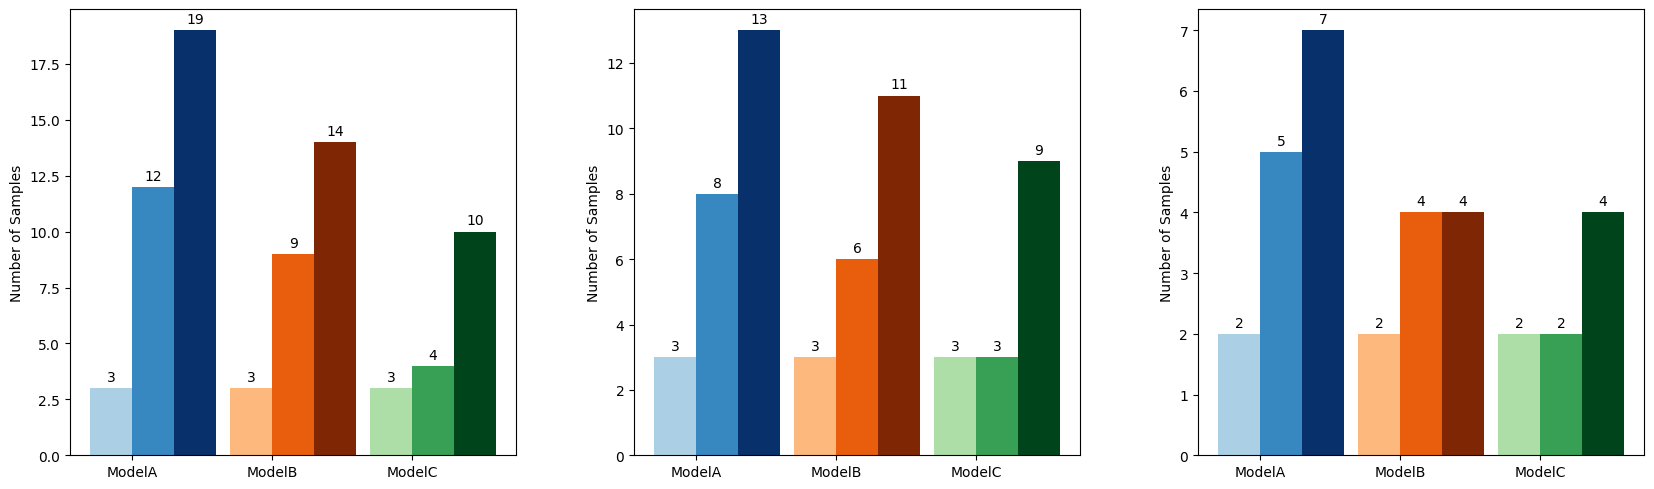

In [5]:
# Example data
def cumulative_bar(ax,thresh): 
    categories = ['ModelA', 'ModelB', 'ModelC']
    values = [[(set_dataA[:15]['yield product'] > thresh).sum().item(), (set_dataA[:30]['yield product'] > thresh).sum().item(), (set_dataA[:]['yield product'] > thresh).sum().item()], #((set_dataA[:15]['yield product'] > thresh).sum().item(), (set_dataB[:15]['yield product'] > thresh).sum().item(),(set_dataC[:15]['yield product'] > thresh).sum().item()),
            [(set_dataB[:15]['yield product'] > thresh).sum().item(), (set_dataB[:30]['yield product'] > thresh).sum().item(), (set_dataB[:]['yield product'] > thresh).sum().item()], 
            [(set_dataC[:15]['yield product'] > thresh).sum().item(), (set_dataC[:30]['yield product'] > thresh).sum().item(), (set_dataC[:]['yield product'] > thresh).sum().item()]]  # Each category has multiple bars
    num_bars_per_category = len(values[0])

    # Create gradient colors for each category
    def generate_gradient_color(base_color, num_shades):
        base_color = np.array(base_color)
        gradient_colors = [base_color * (1-i / (1.5*num_shades)) for i in range(num_shades)]
        return gradient_colors

    # Define some base colors for each category (RGB format)
    base_colors = [(0.1, 0.3, 0.6), (0.9, 0.5, 0.1), (0.2, 0.6, 0.2)]

    # Plot settings
    bar_width = 0.3
    indices = np.arange(len(categories))

    # Plotting each category with gradient bars
    for i, (category, color, value_set) in enumerate(zip(categories, base_colors, values)):
        cmap = {'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}
        gradient_colors = [cmap[category](1 - i / (num_bars_per_category * 1)) for i in range(num_bars_per_category)]
        for j, value in enumerate(value_set):
            rects = ax.bar(indices[i] + j * bar_width, value, width=bar_width, color=gradient_colors[2-j], 
                label=f'{category} - R{j}')
            ax.bar_label(rects, padding=3)

    # Customizing the plot
    ax.set_xticks(indices + bar_width * (num_bars_per_category - 2) / 2)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Number of Samples')
    #ax.set_title(f'Cumulative Count of that Yielded Above {thresh*100}% Threshold')
    ax.set_box_aspect(1)
    # Customizing the legend: this ensures no duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    #ax1.legend(unique_labels.values(), unique_labels.keys(),bbox_to_anchor=(1.5, 0.8))

    plt.tight_layout()

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
cumulative_bar(ax1,thresh = 0.5)
cumulative_bar(ax2,thresh = 0.7)
cumulative_bar(ax3,thresh = 0.9)


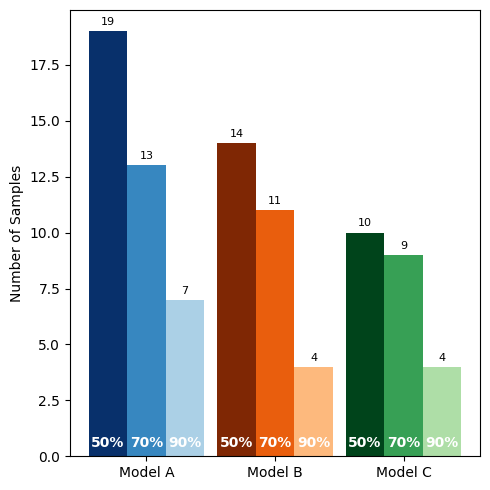

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Example data
thresholds = [0.5, 0.7, 0.9]
counts_A = [19, 13, 7]
counts_B = [14, 11, 4]
counts_C = [10, 9, 4]
model_counts = [counts_A, counts_B, counts_C]
model_names = ['ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()


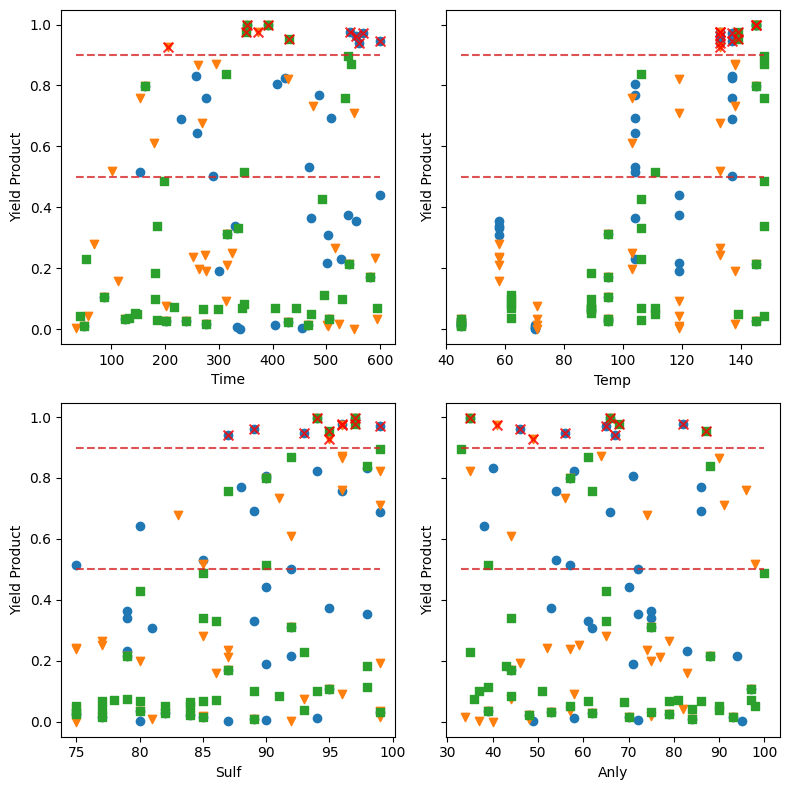

In [ ]:
# Full data
x_all = torch.tensor(all_df[['time', 'temp', 'sulf', 'anly']].values, dtype=dtype)
y_all = torch.tensor(all_df['yield product'].values, dtype=dtype).reshape(-1,1)
labels = ["Time", "Temp", "Sulf", "Anly"]
# Filter Threshold
threshold = 0.9
# Filter the data
filtered_data = all_df[all_df['yield product'] > threshold]
filter_x = torch.tensor(filtered_data[['time','temp','sulf','anly']].values)# 4D input
filter_y = torch.tensor(filtered_data['yield product'].values).reshape(-1,1) # 1D output

xA_all = torch.tensor(set_dataA[['time', 'temp', 'sulf', 'anly']].values, dtype=dtype)
yA_all = torch.tensor(set_dataA['yield product'].values, dtype=dtype).reshape(-1,1)
yA_var = torch.tensor(set_dataA['var yield'].values, dtype=dtype).reshape(-1,1)

xB_all = torch.tensor(set_dataB[['time', 'temp', 'sulf', 'anly']].values, dtype=dtype)
yB_all = torch.tensor(set_dataB['yield product'].values, dtype=dtype).reshape(-1,1)
yB_var = torch.tensor(set_dataB['var yield'].values, dtype=dtype).reshape(-1,1)

xC_all = torch.tensor(set_dataC[['time', 'temp', 'sulf', 'anly']].values, dtype=dtype)
yC_all = torch.tensor(set_dataC['yield product'].values, dtype=dtype).reshape(-1,1)
yC_var = torch.tensor(set_dataC['var yield'].values, dtype=dtype).reshape(-1,1)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        if idx < len(labels):
            # Plot all points
            # ax[i,j].scatter(xA_all[:, idx], yA_all, color='tab:blue', label='ModelA')
            # ax[i,j].scatter(xB_all[:, idx], yB_all, color='tab:orange', label='ModelB')
            # ax[i,j].scatter(xC_all[:, idx], yC_all, color='tab:green', label='ModelC')
            # ax[i,j].errorbar(xA_all[:, idx].squeeze(), yA_all.squeeze(), yerr=np.sqrt(yA_var.squeeze()), fmt='o', color='tab:blue', alpha=0.5)
            # ax[i,j].errorbar(xB_all[:, idx].squeeze(), yB_all.squeeze(), yerr=np.sqrt(yB_var.squeeze()), fmt='o', color='tab:orange', alpha=0.5)
            # ax[i,j].errorbar(xC_all[:, idx].squeeze(), yC_all.squeeze(), yerr=np.sqrt(yC_var.squeeze()), fmt='o', color='tab:green', alpha=0.5)

            # Plot all points
            #cmap = {0: cm.Greys, 1: cm.Greys, 2: cm.Greys}
            colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}
            markers = {0: 'o', 1: 'v', 2: 's'}
            for model_idx, (x_data, y_data, color, marker) in enumerate(zip(
                [xA_all, xB_all, xC_all], 
                [yA_all, yB_all, yC_all], 
                [colors[0], colors[1], colors[2]],
                [markers[0], markers[1], markers[2]]
            )):
                ax[i, j].scatter(x_data[:, idx], y_data, color=color, marker = marker, label=f'Model{chr(65 + model_idx)}')

            ax[i,j].scatter(filter_x[:, idx], filter_y, color='red', marker='x', s=50, label='Filtered Data',alpha=0.8)
            ax[i,j].hlines(0.9, x_all[:, idx].min(), x_all[:, idx].max(), color='tab:red', linestyle='--', label='Threshold', alpha=0.8)
            ax[i,j].hlines(0.5, x_all[:, idx].min(), x_all[:, idx].max(), color='tab:red', linestyle='--', label='Threshold', alpha=0.8)
            ax[i,j].set_xlabel(labels[idx])
            ax[i,j].set_ylabel("Yield Product")

            # # Filter x values where y > 0.9
            # filtered_x = x_all[y_all.squeeze() > 0.9, idx]
            # if len(filtered_x) > 0:
            #     # ax[i, j].set_title(f"Range: {filtered_x.min():.0f} to {filtered_x.max():.0f}")
            #     ax[i, j].set_title(f"Range: {(filtered_x.max() - filtered_x.min()) / (x_all[:, idx].max() - x_all[:, idx].min()):.2f}")
            # else:
            #     ax[i, j].set_title("No values with y > 0.9")
            # ax[i,j].set_box_aspect(1) 


plt.tight_layout()



In [8]:
def gpevaluate(model,grid):
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(grid)
    mean = posterior.mean
    var = posterior.variance
    return mean, var

def data_prep(df,x1,x2,x3,x4,bounds):
    x1 = torch.tensor([df[x1]], dtype=torch.float32).T
    x2 = torch.tensor([df[x2]], dtype=torch.float32).T
    x3 = torch.tensor([df[x3]], dtype=torch.float32).T
    x4 = torch.tensor([df[x4]], dtype=torch.float32).T

    train_x = torch.hstack([x1, x2, x3, x4])
    train_y = torch.tensor(df['yield product'], dtype=torch.float32).reshape(-1, 1)
    train_yvar = torch.tensor(df['var yield'], dtype=torch.float32).reshape(-1, 1)

    norm_x = normalize(train_x, bounds)

    return norm_x, train_y, train_yvar

bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100., 100.]], dtype=torch.float32) #bounds for normalization

full_x = torch.tensor([all_df['time'].to_numpy(),all_df ['temp'].to_numpy(),all_df ['sulf'].to_numpy(),all_df ['anly'].to_numpy()],dtype=torch.float32).T
full_nx = normalize(full_x,bounds)
full_y = torch.tensor(all_df['yield product'].to_numpy(),dtype=torch.float32).reshape(-1,1)
full_yvar = torch.tensor(all_df['var yield'].to_numpy(),dtype=torch.float32).reshape(-1,1)

# Full Model
gp_full = HeteroskedasticSingleTaskGP(full_nx,full_y,full_yvar)#,covar_module=rbf_kernel
mll_full= ExactMarginalLogLikelihood(gp_full .likelihood, gp_full)
fit_gpytorch_model(mll_full)
# Evaluate Full Model
mean_full,var_full = gpevaluate(gp_full,full_nx)

# Partial Model A
normx_A, y_A, yvar_A = data_prep(set_dataA,'time','temp','sulf','anly',bounds)
gp_A = HeteroskedasticSingleTaskGP(normx_A, y_A, yvar_A )#,covar_module=rbf_kernel
mll_A = ExactMarginalLogLikelihood(gp_A.likelihood, gp_A)
fit_gpytorch_model(mll_A)
# Evaluate Partial Model A
mean_A,var_A = gpevaluate(gp_A,normx_A)
# Evalauate Partial Model A with full data set
mean_A_all,var_A_all = gpevaluate(gp_A,full_nx)

# Partial Model B
normx_B, y_B, yvar_B = data_prep(set_dataB,'time','temp','sulf','anly',bounds)
gp_B = HeteroskedasticSingleTaskGP(normx_B, y_B, yvar_B)#,covar_module=rbf_kernel
mll_B= ExactMarginalLogLikelihood(gp_B.likelihood, gp_B)
fit_gpytorch_model(mll_B)
# Evaluate Partial Model B
mean_B,var_B = gpevaluate(gp_B,normx_B)
# Evalauate Partial Model B with full data set
mean_B_all,var_B_all = gpevaluate(gp_B,full_nx)

# Partial Model C
normx_C, y_C, yvar_C = data_prep(set_dataC,'time','temp','sulf','anly',bounds)
gp_C = HeteroskedasticSingleTaskGP(normx_C, y_C, yvar_C)#,covar_module=rbf_kernel
mll_C= ExactMarginalLogLikelihood(gp_C.likelihood, gp_C)
fit_gpytorch_model(mll_C)
# Evaluate Partial Model C
mean_C,var_C = gpevaluate(gp_C,normx_C)
# Evalauate Partial Model C with full data set
mean_C_all,var_C_all = gpevaluate(gp_C,full_nx)


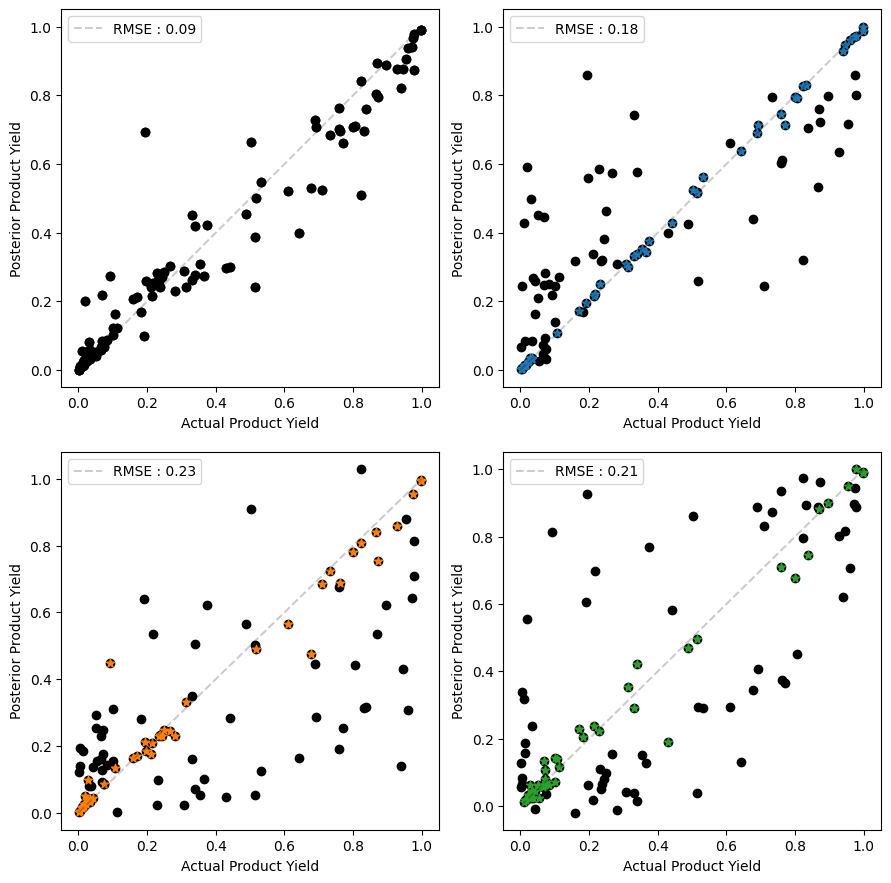

In [9]:
from sklearn.linear_model import LinearRegression
# Function to perform linear regression and plot
def plot_linear_regression(y_real_all, y_pm_all, y_real_model,y_pm_model, ax, xlabel, ylabel, color, marker):
    lin_space = np.linspace(0,1,len(y_pm_all))
    # Calculate the RMSE and MAE of pm vs real
    rmse = torch.sqrt(torch.mean((y_pm_all-y_real_all )** 2))# RMSE of the perfect model
    mae = torch.mean(torch.abs(y_pm_all - y_real_all)) # Mean Absolute Error

    # Create a plot of y = x
    ax.scatter(y_real_all, y_pm_all, color='k')
    ax.scatter(y_real_model, y_pm_model,  color=color, marker = marker) # label='Model')
    ax.plot(lin_space ,lin_space , '--', label=f'RMSE : {rmse:.2f}', color='black', alpha=0.2)

    ax.set_box_aspect(1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')

# Prepare the data
x_full = full_y.reshape(-1, 1)
y_full = mean_full.reshape(-1, 1)

x_A = y_A.reshape(-1, 1)
y_A = mean_A.reshape(-1, 1)
y_A_all = mean_A_all.reshape(-1, 1)

x_B = y_B.reshape(-1, 1)
y_B = mean_B.reshape(-1, 1)
y_B_all = mean_B_all.reshape(-1, 1)

x_C = y_C.reshape(-1, 1)
y_C = mean_C.reshape(-1, 1)
y_C_all = mean_C_all.reshape(-1, 1)


# Create subplots
fig, axs = plt.subplots(2,2 , figsize=(9, 9))
# Plot for full_y vs mean_full
plot_linear_regression(x_full, y_full, x_full, y_full, axs[0, 0], 'Actual Product Yield', 'Posterior Product Yield','k','o')
# plot_linear_regression(torch.zeros(2), torch.zeros(2),  x_A, y_A, axs[0, 0], 'Actual Product Yield', 'Posterior Product Yield','tab:blue', 'o')
# plot_linear_regression(torch.zeros(2), torch.zeros(2),  x_B, y_B, axs[0, 0], 'Actual Product Yield', 'Posterior Product Yield','tab:orange',"v")
# plot_linear_regression(torch.zeros(2), torch.zeros(2),  x_C, y_C, axs[0, 0], 'Actual Product Yield', 'Posterior Product Yield','tab:green','s')



# Plot for y_A vs mean_A
plot_linear_regression(x_full, y_A_all, x_A, y_A,  axs[0, 1], 'Actual Product Yield', 'Posterior Product Yield', 'tab:blue','*')
# Plot for y_B vs mean_B
plot_linear_regression(x_full, y_B_all, x_B, y_B, axs[1, 0],  'Actual Product Yield','Posterior Product Yield','tab:orange','*')
# Plot for y_C vs mean_C
plot_linear_regression(x_full, y_C_all, x_C, y_C, axs[1, 1], 'Actual Product Yield','Posterior Product Yield','tab:green','*')

plt.tight_layout()
plt.show()


  0%|          | 0/45 [00:00<?, ?it/s]

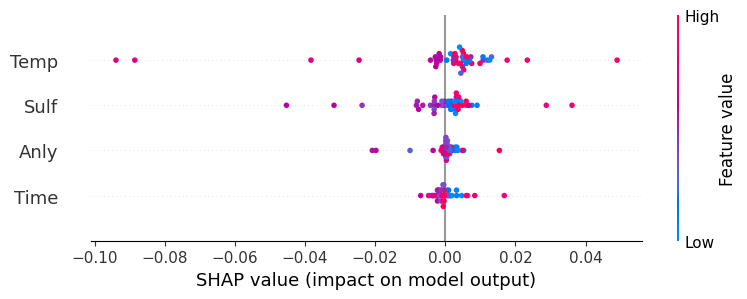

  0%|          | 0/45 [00:00<?, ?it/s]

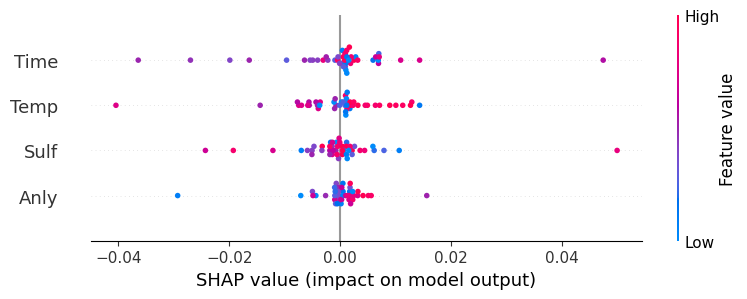

  0%|          | 0/45 [00:00<?, ?it/s]

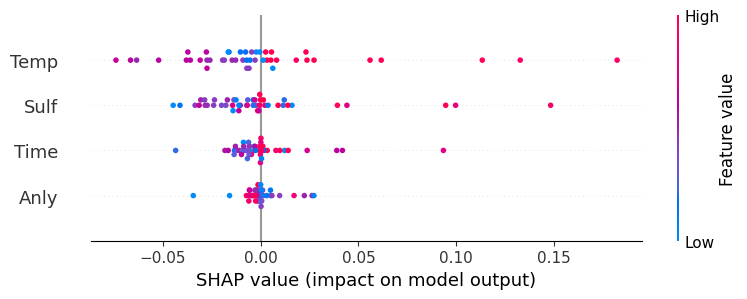

  0%|          | 0/105 [00:00<?, ?it/s]

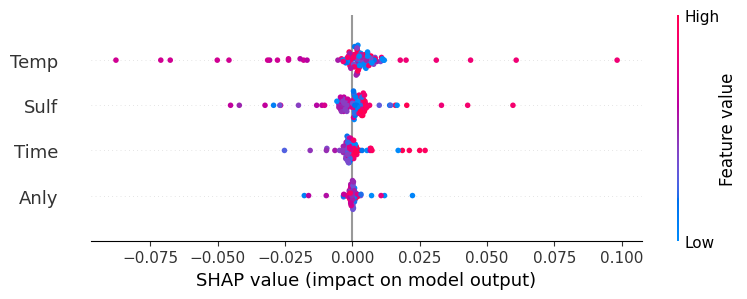

In [10]:
import shap
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define SHAP-compatible prediction function for Model A
def gp_predict(X_scaled_np):
    X_scaled_torch = torch.tensor(X_scaled_np, dtype=torch.float32)
    gp_A.eval()
    with torch.no_grad():
        posterior = gp_A.posterior(X_scaled_torch)
    return posterior.mean.squeeze(-1).numpy()

# Step 1: Normalize the GP input space
scaler = StandardScaler()
xA_all_np = xA_all.numpy()
xA_all_scaled = scaler.fit_transform(xA_all_np)

# Step 3: Run SHAP (use KernelExplainer for model-agnostic GPs)
explainer = shap.KernelExplainer(gp_predict, xA_all_scaled[:100])  # use a subset for background
shap_values = explainer.shap_values(xA_all_scaled)

# Step 4: Plot
shap.summary_plot(shap_values, xA_all_scaled, feature_names=["Time", "Temp", "Sulf", "Anly"])


def gp_predict(X_scaled_np):
    X_scaled_torch = torch.tensor(X_scaled_np, dtype=torch.float32)
    gp_B.eval()
    with torch.no_grad():
        posterior = gp_B.posterior(X_scaled_torch)
    return posterior.mean.squeeze(-1).numpy()

# Step 1: Normalize the GP input space
scaler = StandardScaler()
xB_all_np = xB_all.numpy()
xB_all_scaled = scaler.fit_transform(xB_all_np)

# Step 3: Run SHAP (use KernelExplainer for model-agnostic GPs)
explainer = shap.KernelExplainer(gp_predict, xB_all_scaled[:100])  # use a subset for background
shap_values = explainer.shap_values(xB_all_scaled)

# Step 4: Plot
shap.summary_plot(shap_values, xB_all_scaled, feature_names=["Time", "Temp", "Sulf", "Anly"])


def gp_predict(X_scaled_np):
    X_scaled_torch = torch.tensor(X_scaled_np, dtype=torch.float32)
    gp_C.eval()
    with torch.no_grad():
        posterior = gp_C.posterior(X_scaled_torch)
    return posterior.mean.squeeze(-1).numpy()

# Step 1: Normalize the GP input space
scaler = StandardScaler()
xC_all_np = xC_all.numpy()
xC_all_scaled = scaler.fit_transform(xC_all_np)

# Step 3: Run SHAP (use KernelExplainer for model-agnostic GPs)
explainer = shap.KernelExplainer(gp_predict, xC_all_scaled[:100])  # use a subset for background
shap_values = explainer.shap_values(xC_all_scaled)

# Step 4: Plot
shap.summary_plot(shap_values, xC_all_scaled, feature_names=["Time", "Temp", "Sulf", "Anly"])


# Step 1: Fit the GP model
gp_full = HeteroskedasticSingleTaskGP(full_nx, full_y, full_yvar)
mll_full = ExactMarginalLogLikelihood(gp_full.likelihood, gp_full)
fit_gpytorch_model(mll_full)

# Step 2: Prepare the prediction wrapper for SHAP
def gp_predict(X_scaled_np):
    X_scaled_torch = torch.tensor(X_scaled_np, dtype=torch.float32)
    gp_full.eval()
    with torch.no_grad():
        posterior = gp_full.posterior(X_scaled_torch)
    return posterior.mean.squeeze(-1).numpy()

# Step 3: Normalize the inputs
scaler = StandardScaler()
x_all_np = x_all .numpy()
x_all_scaled = scaler.fit_transform(x_all_np)

# Step 4: Run SHAP (KernelExplainer)
explainer = shap.KernelExplainer(gp_predict, x_all_scaled[:100])  # background dataset
shap_values = explainer.shap_values(x_all_scaled)

# Step 5: Plot SHAP summary
shap.summary_plot(shap_values, x_all_scaled, feature_names=["Time", "Temp", "Sulf", "Anly"])




In [11]:
# # Function to perform linear regression and plot
# def plot_linear_regression(y_real_all, y_pm_all, y_real_model,y_pm_model, var_pm_all, var_real , ax, xlabel, ylabel, color):
#     lin_space = np.linspace(0,1,len(y_pm_all))
#     # Calculate the RMSE and MAE of pm vs real
#     rmse = torch.sqrt(torch.mean((y_pm_all-y_real_all )** 2))# RMSE of the perfect model
#     mae = torch.mean(torch.abs(y_pm_all - y_real_all)) # Mean Absolute Error

#     # Create a plot of y = x
#     # ax.scatter(y_real_all, y_pm_all, color='k')
#     ax.errorbar(y_real_all.squeeze(), y_pm_all.squeeze(),  xerr=(var_real.squeeze()), yerr= np.sqrt(var_pm_all.squeeze()), fmt='o', color='k', alpha=0.1)
#     ax.scatter(y_real_model, y_pm_model,  color=color, marker = "*") # label='Model')
#     ax.plot(lin_space ,lin_space , '--', label=f'RMSE : {rmse:.2f}', color='black', alpha=0.2)
#     # ax.plot(lin_space ,lin_space , '--', label=f'MAE : {mae:.2f}', color='black', alpha=0.2)
#     # ax.plot(lin_space ,lin_space , '--', label=f'RMSE : {rmse_perfect:.2f}', color='black', alpha=0.2)
#     # ax.plot(lin_space ,lin_space , '--', label=f'MAE : {mae_perfect:.2f}', color='black', alpha=0.2)
#     ax.set_box_aspect(1)
    
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.legend(loc='upper left')

# # Prepare the data
# x_full = full_y.reshape(-1, 1)
# y_full = mean_full.reshape(-1, 1)

# x_A = y_A.reshape(-1, 1)
# y_A = mean_A.reshape(-1, 1)
# y_A_all = mean_A_all.reshape(-1, 1)

# x_B = y_B.reshape(-1, 1)
# y_B = mean_B.reshape(-1, 1)
# y_B_all = mean_B_all.reshape(-1, 1)

# x_C = y_C.reshape(-1, 1)
# y_C = mean_C.reshape(-1, 1)
# y_C_all = mean_C_all.reshape(-1, 1)


# # Create subplots
# fig, axs = plt.subplots(2,2 , figsize=(9, 9))
# # Plot for full_y vs mean_full
# plot_linear_regression(x_full, y_full, x_full, y_full, var_full, full_yvar, axs[0, 0], 'Actual Y', 'Posterior Y','k')
# # Plot for y_A vs mean_A
# plot_linear_regression(x_full, y_A_all, x_A, y_A ,var_A_all, full_yvar, axs[0, 1] , 'Actual Y', 'Posterior Y', 'tab:blue')
# # Plot for y_B vs mean_B
# plot_linear_regression(x_full, y_B_all, x_B, y_B, var_B_all, full_yvar, axs[1, 0],  'Actual Y','Posterior Y','tab:orange')
# # Plot for y_C vs mean_C
# plot_linear_regression(x_full, y_C_all, x_C, y_C, var_C_all, full_yvar, axs[1, 1], 'Actual Y','Posterior Y','tab:green')

# plt.tight_layout()
# plt.show()
